In [1]:
# Part 1: Q-Learning and Policy Iteration on the Frozen Lake Environment
import gymnasium as gym
import numpy as np
import pandas as pd

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate, gamma, epsilon):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        # Directly use the state without converting it to an integer
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(self.q_table[state, :])

    def learn(self, state, action, reward, next_state):
        # Directly use the state and next_state without converting them
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state, :])
        self.q_table[state, action] += self.learning_rate * (target - predict)
        
# Training Function
def train_agent(env, agent, episodes=1000):
    rewards = []
    for episode in range(episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            step_result = env.step(action)
            next_state, reward, done = step_result[0], step_result[1], step_result[2]  # Correctly unpack step result
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
    return rewards




# Environment Setup
env = gym.make('FrozenLake-v1', is_slippery=True)

# Hyperparameters
learning_rates = [0.5, 0.8, 0.1]
gammas = [0.9, 0.95, 0.99]
epsilons = [0.1, 0.2, 0.3]

# Analysis DataFrame
results_df = pd.DataFrame(columns=["Learning_Rate", "Gamma", "Epsilon", "Average_Reward"])

# Hyperparameter Tuning and Training
# Inside the loop where you train the agent and calculate average rewards
for alpha in learning_rates:
    for gamma in gammas:
        for epsilon in epsilons:
            agent = QLearningAgent(state_size=env.observation_space.n, action_size=env.action_space.n, learning_rate=alpha, gamma=gamma, epsilon=epsilon)
            rewards = train_agent(env, agent)
            avg_reward = np.mean(rewards)
            new_row = pd.DataFrame({"Learning_Rate": [alpha], "Gamma": [gamma], "Epsilon": [epsilon], "Average_Reward": [avg_reward]})
            results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display Results
print(results_df)

# Close Environment
env.close()


    Learning_Rate  Gamma  Epsilon  Average_Reward
0             0.5   0.90      0.1           0.000
1             0.5   0.90      0.2           0.001
2             0.5   0.90      0.3           0.043
3             0.5   0.95      0.1           0.000
4             0.5   0.95      0.2           0.000
5             0.5   0.95      0.3           0.001
6             0.5   0.99      0.1           0.000
7             0.5   0.99      0.2           0.087
8             0.5   0.99      0.3           0.000
9             0.8   0.90      0.1           0.000
10            0.8   0.90      0.2           0.000
11            0.8   0.90      0.3           0.007
12            0.8   0.95      0.1           0.000
13            0.8   0.95      0.2           0.001
14            0.8   0.95      0.3           0.000
15            0.8   0.99      0.1           0.000
16            0.8   0.99      0.2           0.000
17            0.8   0.99      0.3           0.030
18            0.1   0.90      0.1           0.000


In [2]:
#pip install "gym[atari]"

In [3]:
#pip install "gym[accept-rom-license]"

In [4]:
#!ale-import-roms /Users/vyshali/anaconda3/lib/python3.11/site-packages/AutoROM


In [5]:
#Choose an Atari game environment from the OpenAI Gym library[1].
#Adapt the Q-Learning code from Part 1 to work with the chosen Atari game environment.
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),  # Adjusted for correct input channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        # Assuming x is already in the correct shape (N, C, H, W)
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Agent
class Agent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters())

    def select_action(self, state):
        # Check if state is a tuple and extract the image data
        if isinstance(state, tuple):
            image_data = state[0]  # Assuming the first element of the tuple is the image
        else:
            image_data = state

        # Ensure image_data is a 3D array with shape (H, W, C)
        if image_data.ndim == 3 and image_data.shape[-1] == 3:
            image_data = np.transpose(image_data, (2, 0, 1))  # Rearrange dimensions to (C, H, W)
        elif image_data.ndim != 3 or image_data.shape[0] != 3:
            raise ValueError("Invalid state shape for the DQN network")

        # Convert to PyTorch tensor and normalize
        image_data = torch.tensor([image_data], dtype=torch.float32) / 255.0  # Normalize and add batch dimension

        # Get Q-values from the model and choose the action
        q_values = self.model(image_data)
        action = torch.argmax(q_values).item()
        return action
    
    def update_policy(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample a batch of experiences
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)  # Convert to boolean tensor

        # Current Q-values
        curr_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q-values
        next_q_values = self.model(next_states).max(1)[0]
        next_q_values[dones] = 0.0  # Use boolean indexing

        # Calculate target Q-values
        target_q_values = rewards + self.gamma * next_q_values

        # Compute loss
        loss = F.mse_loss(curr_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Initialize environment, agent, and replay buffer
env = gym.make('Breakout-v0')
state_dim = (3, 210, 160)  # Specify (channels, height, width) for Atari RGB images
action_dim = env.action_space.n
replay_buffer = ReplayBuffer(10000)
gamma = 0.99  # Discount factor for the agent
batch_size = 32  # Batch size for training
agent = Agent(state_dim, action_dim, replay_buffer)
agent.gamma = gamma  # Set the discount factor

# Taking a step in the environment to check the structure of returned values
state = env.reset()
action = env.action_space.sample()
step_output = env.step(action)

# Unpack the step output with the additional boolean value
next_state_data, reward, done, _, info = step_output
next_state = next_state_data  # Assuming the first element is the observation (image data)
print("Shape of next state:", next_state.shape)


# Print detailed information about the step output
print("Step output:", step_output)
print("Type of step output:", type(step_output))
print("Length of step output:", len(step_output))
if isinstance(step_output, tuple):
    for i, element in enumerate(step_output):
        print(f"Element {i}: Type: {type(element)}, Value: {element}")
else:
    print("Step output is not a tuple")

env.close()


Shape of next state: (210, 160, 3)
Step output: (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0.0, False, False, {'lives': 5, 'episode_frame_number': 3, 'frame_number': 3})
Type of step output: <class 'tuple'>
Length of step output: 5
Element 0

/Users/vyshali/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/vyshali/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
#Train your Q-Learning agent on the Atari game environment.

import torch
import random
import numpy as np
from collections import deque
import torch.nn.functional as F
from torch.optim import Adam


# Set up the environment
env = gym.make('Breakout-v0')
state_dim = (3, 210, 160)  # Channels, height, width for Atari RGB images
action_dim = env.action_space.n
replay_buffer = ReplayBuffer(100000)  # Large buffer to store experiences
agent = Agent(state_dim, action_dim, replay_buffer)
agent.gamma = 0.99  # Discount factor
batch_size = 32
learning_rate = 1e-4
agent.optimizer = Adam(agent.model.parameters(), lr=learning_rate)

# Training loop
num_episodes = 20  # Number of episodes to train
epsilon_start = 1.0  # Starting value of epsilon for the epsilon-greedy policy
epsilon_end = 0.01  # Final value of epsilon
epsilon_decay = 0.995  # Decay rate of epsilon per episode

for episode in range(num_episodes):
    reset_output = env.reset()

    # Check the structure of the reset output
    if isinstance(reset_output, tuple):
        state = reset_output[0]  # Assuming the first element is the state
    else:
        state = reset_output

    # Prepare the state for DQN if it's a 3D array
    if isinstance(state, np.ndarray) and state.ndim == 3:
        state = np.transpose(state, (2, 0, 1))  # Convert to (C, H, W)

    total_reward = 0
    done = False
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))

    while not done:
        # Epsilon-greedy policy for exploration
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        step_output = env.step(action)

        # Check the structure of the step output
        if isinstance(step_output, tuple) and len(step_output) >= 4:
            next_state, reward, done, _ = step_output[:4]  # Unpack the first four elements

            # Prepare the next state for DQN
            if isinstance(next_state, np.ndarray) and next_state.ndim == 3:
                next_state = np.transpose(next_state, (2, 0, 1))  # Convert to (C, H, W)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Train the agent
            if len(replay_buffer) > batch_size:
                agent.update_policy(batch_size)

    print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

env.close()


/var/folders/48/hmsj0mgs269c6b1nbsc_pxpc0000gn/T/ipykernel_83110/1287215656.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/torch/csrc/utils/tensor_new.cpp:248.)
  states = torch.tensor(states, dtype=torch.float32)


Episode: 0, Total Reward: 1.0, Epsilon: 1.0
Episode: 1, Total Reward: 2.0, Epsilon: 0.995
Episode: 2, Total Reward: 0.0, Epsilon: 0.990025
Episode: 3, Total Reward: 1.0, Epsilon: 0.985074875
Episode: 4, Total Reward: 2.0, Epsilon: 0.980149500625
Episode: 5, Total Reward: 3.0, Epsilon: 0.975248753121875
Episode: 6, Total Reward: 0.0, Epsilon: 0.9703725093562656
Episode: 7, Total Reward: 1.0, Epsilon: 0.9655206468094842
Episode: 8, Total Reward: 1.0, Epsilon: 0.9606930435754368
Episode: 9, Total Reward: 0.0, Epsilon: 0.9558895783575596
Episode: 10, Total Reward: 3.0, Epsilon: 0.9511101304657719
Episode: 11, Total Reward: 1.0, Epsilon: 0.946354579813443
Episode: 12, Total Reward: 0.0, Epsilon: 0.9416228069143757
Episode: 13, Total Reward: 1.0, Epsilon: 0.9369146928798039
Episode: 14, Total Reward: 2.0, Epsilon: 0.9322301194154049
Episode: 15, Total Reward: 1.0, Epsilon: 0.9275689688183278
Episode: 16, Total Reward: 6.0, Epsilon: 0.9229311239742362
Episode: 17, Total Reward: 5.0, Epsilon: 

In [7]:
#Implement the PPO algorithm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, input_channels, n_actions):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv_out_size = self._get_conv_out((input_channels, 210, 160))
        self.fc = nn.Sequential(
            nn.Linear(self.conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
            nn.Softmax(dim=-1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

    
class ValueNetwork(nn.Module):
    def __init__(self, input_channels):
        super(ValueNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv_out_size = self._get_conv_out((input_channels, 210, 160))
        self.fc = nn.Sequential(
            nn.Linear(self.conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

    
class PPOAgent:
    def __init__(self, policy_net, value_net, policy_optimizer, value_optimizer, gamma, clip_param, gae_lambda):
        self.policy_net = policy_net
        self.value_net = value_net
        self.policy_optimizer = policy_optimizer
        self.value_optimizer = value_optimizer
        self.gamma = gamma
        self.clip_param = clip_param
        self.gae_lambda = gae_lambda  # Added gae_lambda

    def collect_data(self, env, steps):
        states = []
        actions = []
        rewards = []
        old_log_probs = []
        is_terminals = []

        state = env.reset()
        for _ in range(steps):
            # Process state
            state_img = state[0] if isinstance(state, tuple) else state
            state_img = np.transpose(state_img, (2, 0, 1))  # Transpose to (C, H, W)
            state_tensor = torch.from_numpy(state_img).float().unsqueeze(0)  # Add batch dimension

            # Extract action probabilities
            with torch.no_grad():
                action_probs = self.policy_net(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()

            # Perform an action
            step_output = env.step(action.item())

            # Unpack step output with flexibility
            next_state = step_output[0]
            reward = step_output[1]
            done = step_output[2]

            # Append data to lists
            states.append(state_img)
            actions.append(action.item())
            rewards.append(reward)
            old_log_probs.append(distribution.log_prob(action).item())
            is_terminals.append(done)

            state = env.reset() if done else next_state

        return states, actions, rewards, old_log_probs, is_terminals


    def compute_advantages(self, rewards, values, is_terminals):
        advantages = []
        gae = 0  # Generalized Advantage Estimation
        values.append(0)  # Append a dummy value for the terminal state

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - int(is_terminals[t])) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - int(is_terminals[t])) * gae
            advantages.insert(0, gae)

        return advantages


    def ppo_update(self, states, actions, old_log_probs, returns, advantages, update_timesteps):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages, dtype=torch.float32)

        for _ in range(update_timesteps):
            # Get new log probabilities and state values
            new_log_probs = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            state_values = self.value_net(states).squeeze(1)

            # Calculate the ratio (pi_theta / pi_theta_old)
            ratios = torch.exp(new_log_probs - old_log_probs)

            # Calculate surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantages

            # Calculate final loss of the policy gradient
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(state_values, returns)

            # Update policy network
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

            # Update value network
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
            


                
# Set up the environment
env = gym.make('Breakout-v4')
input_channels = 3  # For RGB images
n_actions = env.action_space.n

# Initialize networks and agent
policy_net = PolicyNetwork(input_channels, n_actions)
value_net = ValueNetwork(input_channels)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-4)
gae_lambda = 0.95  # Example value, should be tuned for your environment
agent = PPOAgent(policy_net, value_net, policy_optimizer, value_optimizer, gamma=0.99, clip_param=0.2, gae_lambda=gae_lambda)


In [8]:
# Ensure this function is defined in your script
def compute_returns(rewards, gamma, is_terminals):
    R = 0
    returns = []
    for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
        if is_terminal:
            R = 0
        R = reward + gamma * R
        returns.insert(0, R)
    return returns

# Training Loop
steps_per_episode = 20  # This is an arbitrary number; adjust based on your needs
num_episodes = 5  # Define the number of episodes for training
update_timesteps = 5  # This is an arbitrary number; adjust based on your needs

for episode in range(num_episodes):
    states, actions, rewards, old_log_probs, is_terminals = agent.collect_data(env, steps_per_episode)
    values = [value_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0) / 255.0).item() for state in states]
    
    # Compute returns using the standalone function
    returns = compute_returns(rewards, agent.gamma, is_terminals)
    
    # Compute advantages
    advantages = agent.compute_advantages(rewards, values, is_terminals)
    
    # Perform PPO update
    agent.ppo_update(states, actions, old_log_probs, returns, advantages, update_timesteps)




In [9]:
# Compare the performance of the Q-Learning and PPO agents on the chosen Atari game environment by looking at the mean reward over time.

q_learning_rewards = []

# Example loop for Q-Learning training
for episode in range(num_episodes):
    total_reward = 0
    state = env.reset()
    while not done:
        action = q_learning_agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        q_learning_agent.update_policy(state, action, reward, next_state)
        total_reward += reward
        state = next_state
    q_learning_rewards.append(total_reward)


In [10]:
ppo_rewards = []
log_interval = 10  # Log the progress every 10 episodes

ppo_agent = PPOAgent(policy_net, value_net, policy_optimizer, value_optimizer, gamma=0.99, clip_param=0.2, gae_lambda=gae_lambda)

# Training Loop for PPO
for episode in range(num_episodes):
    # Data collection
    states, actions, rewards, old_log_probs, is_terminals = ppo_agent.collect_data(env, steps_per_episode)

    # Compute total reward for the current episode
    total_reward = sum(rewards)
    ppo_rewards.append(total_reward)

    # Convert and normalize states before passing them to the value network
    values = [ppo_agent.value_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0) / 255.0).item() for state in states]
    
    # Compute returns
    returns = compute_returns(rewards, ppo_agent.gamma, is_terminals)

    # Compute advantages
    advantages = ppo_agent.compute_advantages(rewards, values, is_terminals)
    
    # Update policy and value networks
    ppo_agent.ppo_update(states, actions, old_log_probs, returns, advantages, update_timesteps)
    
    # Optional: logging for monitoring
    if episode % log_interval == 0:
        print(f"Episode {episode}: Total Reward: {total_reward}")



Episode 0: Total Reward: 0.0


In [11]:
def calculate_mean_rewards(rewards, window_size=100):
    mean_rewards = [np.mean(rewards[max(0, i-window_size):(i+1)]) for i in range(len(rewards))]
    return mean_rewards


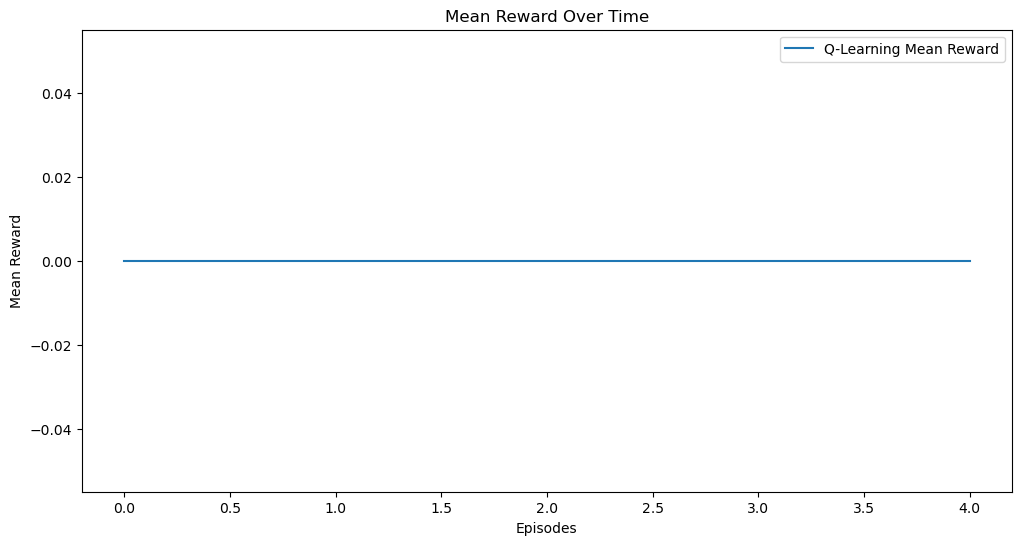

In [12]:
import matplotlib.pyplot as plt

# Calculate mean rewards for both agents
mean_q_learning_rewards = calculate_mean_rewards(q_learning_rewards)
mean_ppo_rewards = calculate_mean_rewards(ppo_rewards)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_q_learning_rewards, label='Q-Learning Mean Reward')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward Over Time')
plt.legend()
plt.show()


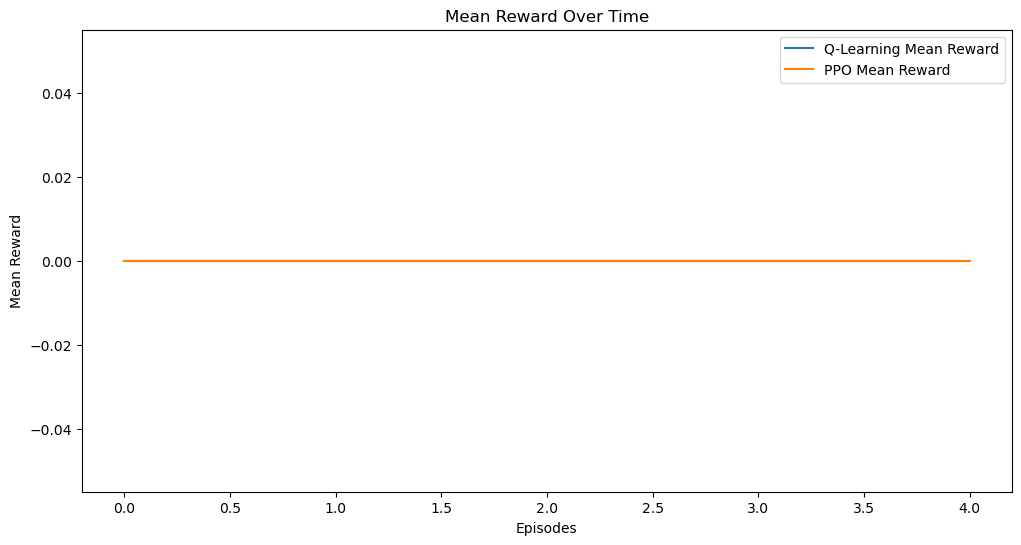

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_q_learning_rewards, label='Q-Learning Mean Reward')
plt.plot(mean_ppo_rewards, label='PPO Mean Reward')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward Over Time')
plt.legend()
plt.show()
